
Processing Layer: Conv1 of type: Conv
  Input Memory: 147.00 KB
  Output Memory: 784.00 KB
  Peak Memory Using 3 Buffers: 1715.00 KB

Processing Layer: MaxPool1 of type: MaxPool
  Input Memory: 784.00 KB
  Layer MaxPool1 of type MaxPool is missing 'filters'. Using input channels instead.
  Output Memory: 189.06 KB
  Peak Memory Using 3 Buffers: 1757.06 KB

Processing Layer: ResidualBlock1_1 of type: ResidualBlock
  Input Memory: 196.00 KB
  Output Memory: 196.00 KB
  Peak Memory Using 3 Buffers: 588.00 KB

Processing Layer: ResidualBlock1_2 of type: ResidualBlock
  Input Memory: 196.00 KB
  Output Memory: 196.00 KB
  Peak Memory Using 3 Buffers: 588.00 KB

Processing Layer: ResidualBlock2_1 of type: ResidualBlock
  Input Memory: 196.00 KB
  Output Memory: 392.00 KB
  Peak Memory Using 3 Buffers: 980.00 KB

Processing Layer: ResidualBlock2_2 of type: ResidualBlock
  Input Memory: 98.00 KB
  Output Memory: 98.00 KB
  Peak Memory Using 3 Buffers: 294.00 KB

Processing Layer: ResidualBloc

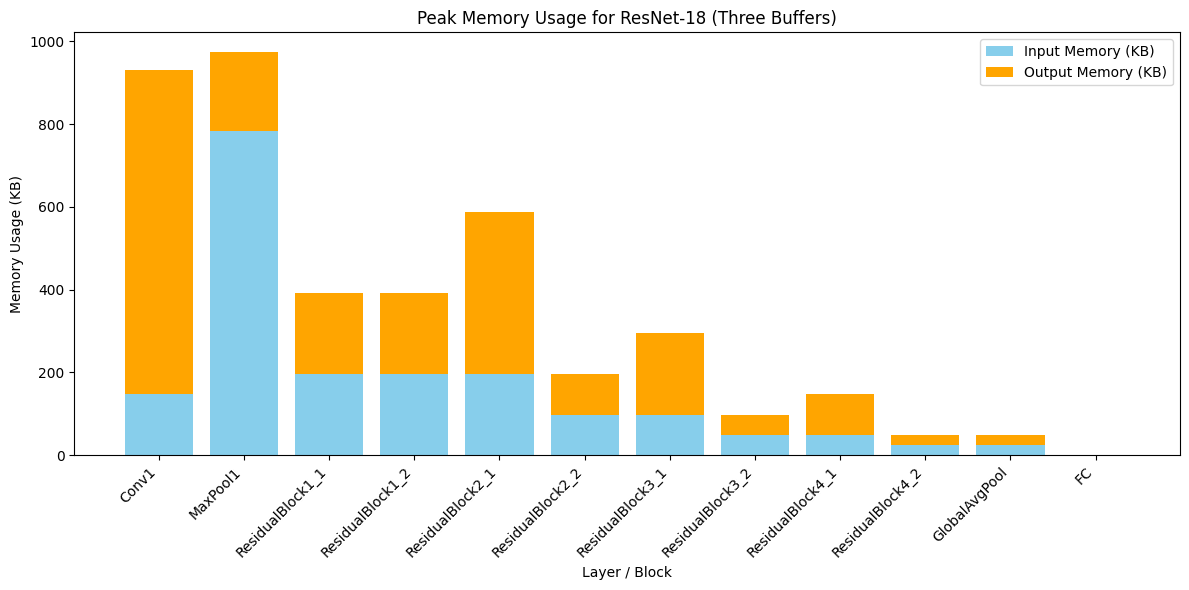

In [13]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load the ResNet-18 architecture from the JSON file
def load_resnet18_architecture(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

# Calculate memory size for a given shape and precision
def calculate_memory(shape, precision='int8'):
    data_type_size = {'int8': 1, 'float32': 4}
    byte_size = data_type_size[precision]
    return np.prod(shape) * byte_size / 1024  # Convert to KB

# Calculate the peak memory usage for ResNet-18
def calculate_resnet18_memory(layers, precision='int8'):
    memory_usage = {}
    for layer in layers:
        print(f"\nProcessing Layer: {layer['name']} of type: {layer['type']}")  # Debug log

        if layer['type'] == 'ResidualBlock':
            # Calculate memory for the entire Residual Block
            input_memory = calculate_memory(layer['input_shape'], precision)
            print(f"  Input Memory: {input_memory:.2f} KB")

            last_layer = layer['layers'][-1]
            if 'filters' in last_layer:
                filters = last_layer['filters']
            else:
                print(f"  Layer {last_layer['name']} is missing 'filters' attribute, using input channels.")
                filters = layer['input_shape'][2]

            # Calculate output shape of the ResidualBlock based on the last layer
            stride = last_layer.get('stride', 1)  # Default stride to 1 if missing
            if 'filter_size' in last_layer:
                output_shape = [
                    (layer['input_shape'][0] - last_layer['filter_size'][0] + 2 * last_layer['padding']) // stride + 1,
                    (layer['input_shape'][1] - last_layer['filter_size'][1] + 2 * last_layer['padding']) // stride + 1,
                    filters
                ]
            else:
                output_shape = [layer['input_shape'][0], layer['input_shape'][1], filters]  # If missing, retain shape

            output_memory = calculate_memory(output_shape, precision)
            print(f"  Output Memory: {output_memory:.2f} KB")

            # Calculate the peak memory using three buffers
            peak_memory = input_memory + output_memory + max(input_memory, output_memory)
            print(f"  Peak Memory Using 3 Buffers: {peak_memory:.2f} KB")

            memory_usage[layer['name']] = {"input_memory": input_memory, "output_memory": output_memory, "peak_memory": peak_memory}
        else:
            # For individual Conv or Pooling layers
            input_memory = calculate_memory(layer['input_shape'], precision)
            print(f"  Input Memory: {input_memory:.2f} KB")

            if 'filters' in layer:
                filters = layer['filters']
            else:
                print(f"  Layer {layer['name']} of type {layer['type']} is missing 'filters'. Using input channels instead.")
                filters = layer['input_shape'][2]

            # Calculate output shape based on layer type
            stride = layer.get('stride', 1)  # Use default stride if not available
            if 'filter_size' in layer:
                output_shape = [
                    (layer['input_shape'][0] - layer['filter_size'][0] + 2 * layer['padding']) // stride + 1,
                    (layer['input_shape'][1] - layer['filter_size'][1] + 2 * layer['padding']) // stride + 1,
                    filters
                ]
            else:
                # Handle cases like MaxPool or GlobalAvgPool where no filter size is involved
                output_shape = [layer['input_shape'][0] // stride, layer['input_shape'][1] // stride, filters]

            output_memory = calculate_memory(output_shape, precision)
            print(f"  Output Memory: {output_memory:.2f} KB")

            # Calculate peak memory with three buffers
            peak_memory = input_memory + output_memory + max(input_memory, output_memory)
            print(f"  Peak Memory Using 3 Buffers: {peak_memory:.2f} KB")

            memory_usage[layer['name']] = {"input_memory": input_memory, "output_memory": output_memory, "peak_memory": peak_memory}

    return memory_usage

# Plot the peak memory usage for ResNet-18
def plot_resnet18_memory(memory_usage, model_name='ResNet-18'):
    layer_names = list(memory_usage.keys())
    input_memory = [memory_usage[layer]['input_memory'] for layer in layer_names]
    output_memory = [memory_usage[layer]['output_memory'] for layer in layer_names]

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(layer_names)), input_memory, label='Input Memory (KB)', color='skyblue')
    plt.bar(range(len(layer_names)), output_memory, bottom=input_memory, label='Output Memory (KB)', color='orange')
    plt.xticks(range(len(layer_names)), layer_names, rotation=45, ha='right')
    plt.xlabel('Layer / Block')
    plt.ylabel('Memory Usage (KB)')
    plt.title(f"Peak Memory Usage for {model_name} (Three Buffers)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Main function for ResNet-18 memory calculation and visualization
def main():
    json_path = "resnet18.json"  # Specify your ResNet-18 JSON file path here
    model_layers = load_resnet18_architecture(json_path)
    memory_usage = calculate_resnet18_memory(model_layers, precision='int8')
    plot_resnet18_memory(memory_usage, model_name='ResNet-18')

if __name__ == '__main__':
    main()